# **Pengumpulan Dataset**

In [ ]:
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd
import time

app_id = "com.traveloka.android"
target = 10000  # target review
batch = 200     # ukuran batch per request

all_reviews = []
token = None

while True:
    result, token = reviews(
        app_id,
        lang="id",
        country="id",
        sort=Sort.NEWEST,
        count=batch,
        continuation_token=token
    )

    all_reviews.extend(result)
    if not token or len(all_reviews) >= target:
        break
    time.sleep(0.2)

df_trav = pd.DataFrame(all_reviews).drop_duplicates(subset="content")
df_trav = df_trav.sort_values("at", ascending=False).reset_index(drop=True)
print("Total data hasil scraping dan menghapus duplikat:", len(df_trav.index))

Total data hasil scraping dan menghapus duplikat: 6009


In [ ]:
total_chars = df_trav["content"].tail(6116).astype(str).str.len().sum()
print("Total karakter di Kolom Content:", total_chars)

Total karakter di Kolom Content: 499727


In [ ]:
df_trav.tail(6116).to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/unique_traveloka_reviews.csv", index=False, encoding='utf-8-sig')
print(f"Data berhasil disimpan di Google Drive")

Data berhasil disimpan di Google Drive


# **Penerjemahan DeepL Translate**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/unique_traveloka_reviews.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df[["at", "userName", "score", "content"]]

,at,userName,score,content
0,2025-09-26 11:01:27,Evita Silalahi,1,kecewa dgn Traveloka pembayaran tetap waktu tp...
1,2025-09-26 10:10:30,Hadi Suharto,5,cepat tepat singkat luar biasa
2,2025-09-26 07:35:57,Kisna Wati,5,puas dengan aplikasi ini 👍
3,2025-09-26 07:22:16,Elbi Plg,5,Sangat memuaskan proses cepat
4,2025-09-26 07:09:38,Bon Lajan,5,Mantap 💯🙏
...,...,...,...,...
6112,2024-07-26 17:43:59,Nur Maell,5,Mantab wooo
6113,2024-07-26 17:31:18,Nur Khofifah,5,Knp aplikasi sya tdk bsa check in online
6114,2024-07-26 15:46:38,Freddy Tedjasendjaja,1,"Book hotel 2x, sdh byr, dan dua²nya cancel tan..."
6115,2024-07-26 15:12:13,Arya Herman,5,Membantu banget


In [ ]:
!pip install -q pandas requests
import pandas as pd
import requests

api_key = "2fb5a8db-ba91-48d2-b459-ab387677b2cf:fx"
deepl_url = "https://api-free.deepl.com/v2/translate"

def deepl_translate_batch(texts, target_lang="EN"):
    data = [("auth_key", api_key), ("target_lang", target_lang)]
    data += [("text", t if isinstance(t, str) else "") for t in texts]

    # kirim request ke API DeepL
    r = requests.post(deepl_url, data=data, timeout=30)
    r.raise_for_status()
    return [tr["text"] for tr in r.json()["translations"]]

batch_size = 50
translated = []
vals = df["content"].fillna("").tolist()

for i in range(0, len(vals), batch_size):
    # ambil potongan (section) teks
    section = vals[i:i+batch_size]
    translated.extend(deepl_translate_batch(section, target_lang="EN"))

df["content_en"] = translated

# simpan ke csv
output_path = "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/data_translated.csv"
df.to_csv(output_path, index=False)
print("Translasi selesai. File tersimpan di:", output_path)

Translasi selesai. File tersimpan di: /content/drive/MyDrive/Colab Notebooks/Tugas Akhir/data_translated.csv


In [ ]:
df_trans = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/data_translated.csv")
df_trans[["content", "content_en"]]

,content,content_en
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,disappointed with Traveloka fixed payment time...
1,cepat tepat singkat luar biasa,fast precise short excellent
2,puas dengan aplikasi ini 👍,satisfied with this app 👍
3,Sangat memuaskan proses cepat,Very satisfying fast process
4,Mantap 💯🙏,Great 💯🙏
...,...,...
6112,Mantab wooo,Mantab wooo
6113,Knp aplikasi sya tdk bsa check in online,Why can't I check in online?
6114,"Book hotel 2x, sdh byr, dan dua²nya cancel tan...","Book hotel 2x, already byr, and both canceled ..."
6115,Membantu banget,Really helpful


# **Labeling Dataset**

## **VADER Sentiment**

In [1]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/data_translated.csv")
df[["content", "content_en"]]

,content,content_en
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,disappointed with Traveloka fixed payment time...
1,cepat tepat singkat luar biasa,fast precise short excellent
2,puas dengan aplikasi ini 👍,satisfied with this app 👍
3,Sangat memuaskan proses cepat,Very satisfying fast process
4,Mantap 💯🙏,Great 💯🙏
...,...,...
6112,Mantab wooo,Mantab wooo
6113,Knp aplikasi sya tdk bsa check in online,Why can't I check in online?
6114,"Book hotel 2x, sdh byr, dan dua²nya cancel tan...","Book hotel 2x, already byr, and both canceled ..."
6115,Membantu banget,Really helpful


In [2]:
!pip install VaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np

# Inisialisasi VADER dan fill NaN untuk menghindari error
vader = SentimentIntensityAnalyzer()
df["content_en"] = df["content_en"].fillna("")

# Hitung skor compound
compound = [vader.polarity_scores(x) for x in df["content_en"]]
df["compound_score"] = [x["compound"] for x in compound]

# df["compound_score"] = df["content_en"].apply(lambda x: vader.polarity_scores(x)["compound"])

# Normalisasi skor compound VADER dari rentang [-1, 1] ke rentang [0, 10] (min-max normalization)
def normalisasi_vader(compound_score):
    return 5 * (compound_score + 1)

df["vader_norm"] = df["compound_score"].apply(normalisasi_vader)

# Label kelas VADER
def label_sentiment_vader(compound_score):
    if np.isnan(compound_score):
        return np.nan
    if compound_score >= 0.05:
        return 1  # Positif
    elif compound_score <= -0.05:
        return -1 # Negatif
    else:
        return 0  # Netral

df["vader_label"] = df["compound_score"].apply(label_sentiment_vader)

print("Setelah VADER:")
df[["content", "content_en",
    "compound_score", "vader_norm", "vader_label"
]].head(50)

Setelah VADER:


,content,content_en,compound_score,vader_norm,vader_label
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,disappointed with Traveloka fixed payment time...,-0.6486,1.7570,-1
1,cepat tepat singkat luar biasa,fast precise short excellent,0.5719,7.8595,1
2,puas dengan aplikasi ini 👍,satisfied with this app 👍,0.4215,7.1075,1
3,Sangat memuaskan proses cepat,Very satisfying fast process,0.5095,7.5475,1
4,Mantap 💯🙏,Great 💯🙏,0.6249,8.1245,1
5,. d .. 'zzo,. d .. 'zzo,0.0000,5.0000,0
6,Good job....,Good job....,0.4404,7.2020,1
7,mudah pesan hotel dan banyak promonya,Easy to book hotels and lots of promotions,0.4404,7.2020,1
8,mudah dan aman,easy and safe,0.7003,8.5015,1
9,terima kasih,Thank you.,0.3612,6.8060,1


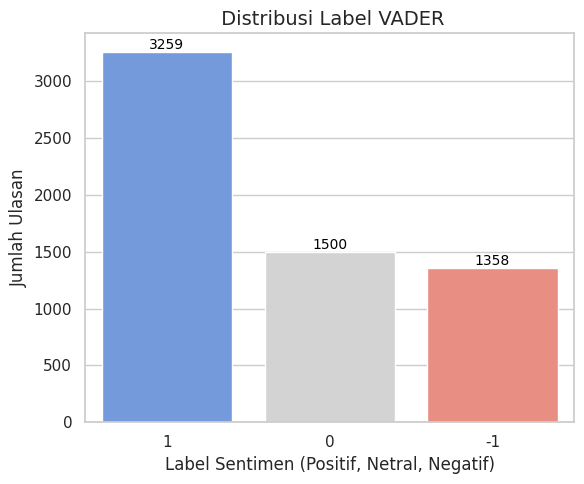

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# plot
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df,
                   x="vader_label",
                   hue="vader_label",
                   palette={1: "cornflowerblue", 0: "lightgrey", -1: "salmon"},
                   order=[1, 0, -1],
                   legend=False)
# label
plt.title(" Distribusi Label VADER", fontsize=14)
plt.xlabel("Label Sentimen (Positif, Netral, Negatif)")
plt.ylabel("Jumlah Ulasan")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="center", fontsize=10, color="black",
                xytext=(0, 5), textcoords="offset points")

plt.tight_layout()
plt.show()

## **AFINN**

In [ ]:
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53431 sha256=0e57068738ba365710541b57533944442588a285e37f397a78c3ba455140b95a
  Stored in directory: /root/.cache/pip/wheels/f9/72/27/74994e77200dae3d6aea2b546264500cee21f738c51241320b
Successfully built afinn


In [ ]:
from afinn import Afinn
import numpy as np

afinn = Afinn()
afinn_scores = []

# Hitung skor AFINN
for text in df["content_en"]:
    if isinstance(text, str):
        score = afinn.score(text)
        afinn_scores.append(score)
    else:
        afinn_scores.append(np.nan)

df["score"] = afinn_scores

# Normalisasi AFINN pakai nilai absolute maksimal lalu min-max normalization
max_abs_afinn = np.nanmax(np.abs(df["score"].values))

def normalisasi_afinn(score, max_abs = max_abs_afinn):
  if np.isnan(score):
    return np.nan

  if max_abs == 0:           # Jika semua skor 0, semua netral
    return 5.0

  scaled = score / max_abs   # hasil dalam [-1, 1]
  return 5 * (scaled + 1)    # pindah ke [0, 10]

df["afinn_norm"] = df["score"].apply(normalisasi_afinn)

# Label kelas AFINN
def label_sentiment_afinn(score):
    if np.isnan(score):
        return np.nan
    if score > 0:
        return 1  # Positif
    elif score < 0:
        return -1 # Negatif
    else:
        return 0  # Netral

df["afinn_label"] = df["score"].apply(label_sentiment_afinn)

print("Setelah VADER dan AFINN:")
df[["content", "content_en",
    "compound_score", "vader_norm", "vader_label",
    "score", "afinn_norm", "afinn_label"
]].head(50)

Setelah VADER dan AFINN:


,content,content_en,compound_score,vader_norm,vader_label,score,afinn_norm,afinn_label
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,disappointed with Traveloka fixed payment time...,-0.6486,1.7570,-1,-2.0,4.411765,-1
1,cepat tepat singkat luar biasa,fast precise short excellent,0.5719,7.8595,1,3.0,5.882353,1
2,puas dengan aplikasi ini 👍,satisfied with this app 👍,0.4215,7.1075,1,2.0,5.588235,1
3,Sangat memuaskan proses cepat,Very satisfying fast process,0.5095,7.5475,1,0.0,5.000000,0
4,Mantap 💯🙏,Great 💯🙏,0.6249,8.1245,1,3.0,5.882353,1
5,. d .. 'zzo,. d .. 'zzo,0.0000,5.0000,0,0.0,5.000000,0
6,Good job....,Good job....,0.4404,7.2020,1,3.0,5.882353,1
7,mudah pesan hotel dan banyak promonya,Easy to book hotels and lots of promotions,0.4404,7.2020,1,1.0,5.294118,1
8,mudah dan aman,easy and safe,0.7003,8.5015,1,2.0,5.588235,1
9,terima kasih,Thank you.,0.3612,6.8060,1,2.0,5.588235,1


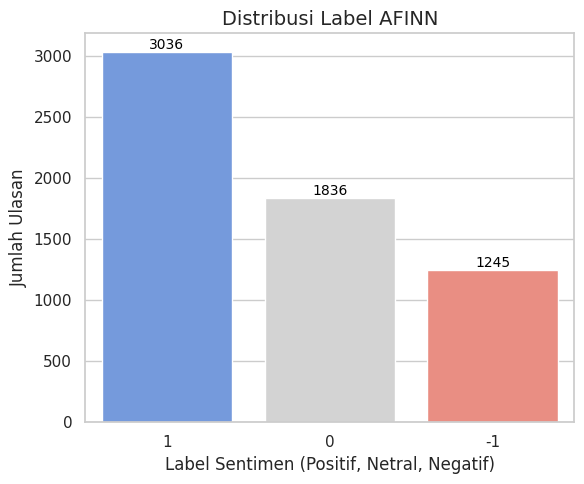

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# plot
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df,
                   x="afinn_label",
                   hue="afinn_label",
                   palette={1: "cornflowerblue", 0: "lightgrey", -1: "salmon"},
                   order=[1, 0, -1],
                   legend=False)

# label
plt.title("Distribusi Label AFINN", fontsize=14)
plt.xlabel("Label Sentimen (Positif, Netral, Negatif)")
plt.ylabel("Jumlah Ulasan")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="center", fontsize=10, color="black",
                xytext=(0, 5), textcoords="offset points")

plt.tight_layout()
plt.show()

## **TextBlob**

In [ ]:
!pip install textblob

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = 

In [ ]:
from textblob import TextBlob
import numpy as np

# Hitung skor polaritas TextBlob
textblob_polarities = []
for text in df['content_en']:
  if isinstance(text, str):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        textblob_polarities.append(polarity)
  else:
        textblob_polarities.append(np.nan)

df['polarity_score'] = textblob_polarities

# Normalisasi skor TextBlob dari rentang [-1, 1] ke rentang [0, 10] (min-max normalization)
def normalisasi_textblob(polarity_score):
  if np.isnan(polarity_score):
    return np.nan
  return 5 * (polarity_score + 1)

df["textblob_norm"] = df["polarity_score"].apply(normalisasi_textblob)

# Label kelas TextBlob
def label_sentiment_textblob(polarity_score):
    if np.isnan(polarity_score):
        return np.nan
    if polarity_score > 0:
        return 1  # Positif
    elif polarity_score < 0:
        return -1 # Negatif
    else:
        return 0  # Netral

df["textblob_label"] = df['polarity_score'].apply(label_sentiment_textblob)

print("Setelah VADER, AFINN, dan TextBlob:")
display(df[[
    "content", "content_en",
    "compound_score", "vader_norm", "vader_label",
    "score", "afinn_norm", "afinn_label",
    "polarity_score", "textblob_norm", "textblob_label"
]].head(50))

Setelah VADER, AFINN, dan TextBlob:


,content,content_en,compound_score,vader_norm,vader_label,score,afinn_norm,afinn_label,polarity_score,textblob_norm,textblob_label
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,disappointed with Traveloka fixed payment time...,-0.6486,1.7570,-1,-2.0,4.411765,-1,-0.466667,2.666667,-1
1,cepat tepat singkat luar biasa,fast precise short excellent,0.5719,7.8595,1,3.0,5.882353,1,0.400000,7.000000,1
2,puas dengan aplikasi ini 👍,satisfied with this app 👍,0.4215,7.1075,1,2.0,5.588235,1,0.500000,7.500000,1
3,Sangat memuaskan proses cepat,Very satisfying fast process,0.5095,7.5475,1,0.0,5.000000,0,0.425000,7.125000,1
4,Mantap 💯🙏,Great 💯🙏,0.6249,8.1245,1,3.0,5.882353,1,0.800000,9.000000,1
5,. d .. 'zzo,. d .. 'zzo,0.0000,5.0000,0,0.0,5.000000,0,0.000000,5.000000,0
6,Good job....,Good job....,0.4404,7.2020,1,3.0,5.882353,1,0.700000,8.500000,1
7,mudah pesan hotel dan banyak promonya,Easy to book hotels and lots of promotions,0.4404,7.2020,1,1.0,5.294118,1,0.433333,7.166667,1
8,mudah dan aman,easy and safe,0.7003,8.5015,1,2.0,5.588235,1,0.466667,7.333333,1
9,terima kasih,Thank you.,0.3612,6.8060,1,2.0,5.588235,1,0.000000,5.000000,0


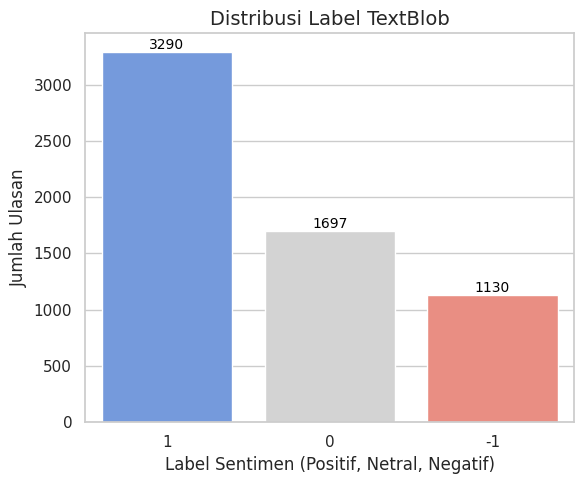

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# plot
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df,
                   x="textblob_label",
                   hue="textblob_label",
                   palette={1: "cornflowerblue", 0: "lightgrey", -1: "salmon"},
                   order=[1, 0, -1],
                   legend=False)

# label
plt.title("Distribusi Label TextBlob", fontsize=14)
plt.xlabel("Label Sentimen (Positif, Netral, Negatif)")
plt.ylabel("Jumlah Ulasan")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# columns_to_save = ["content", "content_en", "compound_score", "label_vader", "score", "label_afinn", "polarity_score", "label_textblob"]
# df_subset = df[columns_to_save]
# df_subset.to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/lexicon_labels.csv", index=False, encoding="utf-8-sig")
# print(f"Data Traveloka reviews berhasil disimpan di Google Drive.")

Data Traveloka reviews berhasil disimpan di Google Drive.


## **Soft Voting**

### **Tanpa Normalisasi**

In [ ]:
import pandas as pd
import numpy as np

# Hitung average score sentimen
df['avg_score'] = df[['compound_score', 'score', 'polarity_score']].mean(axis=1)

# Fungsi labeling skor rata-rata
def label_sentiment_soft_voting(avg_score):
    if np.isnan(avg_score):
        return np.nan
    if avg_score > 0:
        return 1  # Positif
    elif avg_score < 0:
        return -1 # Negatif
    else:
        return 0  # Netral

# Label baru
df['soft_voting_label'] = df['avg_score'].apply(label_sentiment_soft_voting)

print("Soft Voting Labels:")
df[["content", "content_en",
    "compound_score", "vader_norm", "vader_label",
    "score", "afinn_norm", "afinn_label",
    "polarity_score", "textblob_norm", "textblob_label",
    "avg_score", "soft_voting_label"]]
display(df[["avg_score", "soft_voting_label"]].head(50))

Soft Voting Labels:


,avg_score,soft_voting_label
0,-1.038422,-1
1,1.323967,1
2,0.973833,1
3,0.311500,1
4,1.474967,1
5,0.000000,0
6,1.380133,1
7,0.624578,1
8,1.055656,1
9,0.787067,1


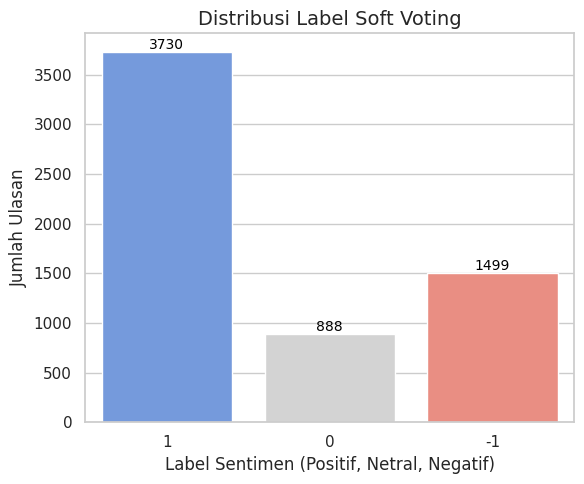

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# plot
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df,
                   x="soft_voting_label",
                   hue="soft_voting_label",
                   palette={1: "cornflowerblue", 0: "lightgrey", -1: "salmon"},
                   order=[1, 0, -1],
                   legend=False)

# label
plt.title("Distribusi Label Soft Voting", fontsize=14)
plt.xlabel("Label Sentimen (Positif, Netral, Negatif)")
plt.ylabel("Jumlah Ulasan")

for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### **Normalisasi 1-5**

In [ ]:
import pandas as pd
import numpy as np

# Hitung rata-rata skor normalisasi [0, 10]
df["avg_norm"] = df[["vader_norm", "afinn_norm", "textblob_norm"]].mean(axis=1)

# Fungsi umum untuk pelabelan soft voting dengan parameter fleksibel
def label_sentiment_soft_voting(avg_norm, pos_thresh, neg_thresh):

    """
    pos_thresh : batas bawah kelas positif
    neg_thresh : batas atas kelas negatif
    """
    if np.isnan(avg_norm):
        return np.nan
    if avg_norm >= pos_thresh:
        return 1   # Positif
    elif avg_norm <= neg_thresh:
        return -1  # Negatif
    else:
        return 0   # Netral

# Tiga  label soft voting dengan parameter berbeda
# Norm 1: threshold (5.5, 4.5)
df["sv_label_norm1"] = df["avg_norm"].apply(
    lambda x: label_sentiment_soft_voting(x, pos_thresh=5.5, neg_thresh=4.5))

# Norm 2: threshold (5.8, 4.8)
df["sv_label_norm2"] = df["avg_norm"].apply(
    lambda x: label_sentiment_soft_voting(x, pos_thresh=5.8, neg_thresh=4.8))

# Norm 3: threshold (6, 4)
df["sv_label_norm3"] = df["avg_norm"].apply(
    lambda x: label_sentiment_soft_voting(x, pos_thresh=6.0, neg_thresh=4.0))

# Norm 4: threshold (6.2, 3.8)
df["sv_label_norm4"] = df["avg_norm"].apply(
    lambda x: label_sentiment_soft_voting(x, pos_thresh=6.2, neg_thresh=3.8))

# Norm 5: threshold (6.5, 3.5)
df["sv_label_norm5"] = df["avg_norm"].apply(
    lambda x: label_sentiment_soft_voting(x, pos_thresh=6.5, neg_thresh=3.5))

print("Soft Voting Labels + Norm 1-5:")
df[["content", "content_en",
    "compound_score", "vader_norm", "vader_label",
    "score", "afinn_norm", "afinn_label",
    "polarity_score", "textblob_norm", "textblob_label",
    "avg_score", "soft_voting_label",
    "avg_norm", "sv_label_norm1", "sv_label_norm2", "sv_label_norm3", "sv_label_norm4", "sv_label_norm5"]]
display(df[["avg_score", "soft_voting_label", "avg_norm", "sv_label_norm1", "sv_label_norm2", "sv_label_norm3", "sv_label_norm4", "sv_label_norm5"]].head(50))

Soft Voting Labels + Norm 1-5:


,avg_score,soft_voting_label,avg_norm,sv_label_norm1,sv_label_norm2,sv_label_norm3,sv_label_norm4,sv_label_norm5
0,-1.038422,-1,2.945144,-1,-1,-1,-1,-1
1,1.323967,1,6.913951,1,1,1,1,1
2,0.973833,1,6.731912,1,1,1,1,1
3,0.311500,1,6.557500,1,1,1,1,1
4,1.474967,1,7.668951,1,1,1,1,1
5,0.000000,0,5.000000,0,0,0,0,0
6,1.380133,1,7.194784,1,1,1,1,1
7,0.624578,1,6.554261,1,1,1,1,1
8,1.055656,1,7.141023,1,1,1,1,1
9,0.787067,1,5.798078,1,0,0,0,0


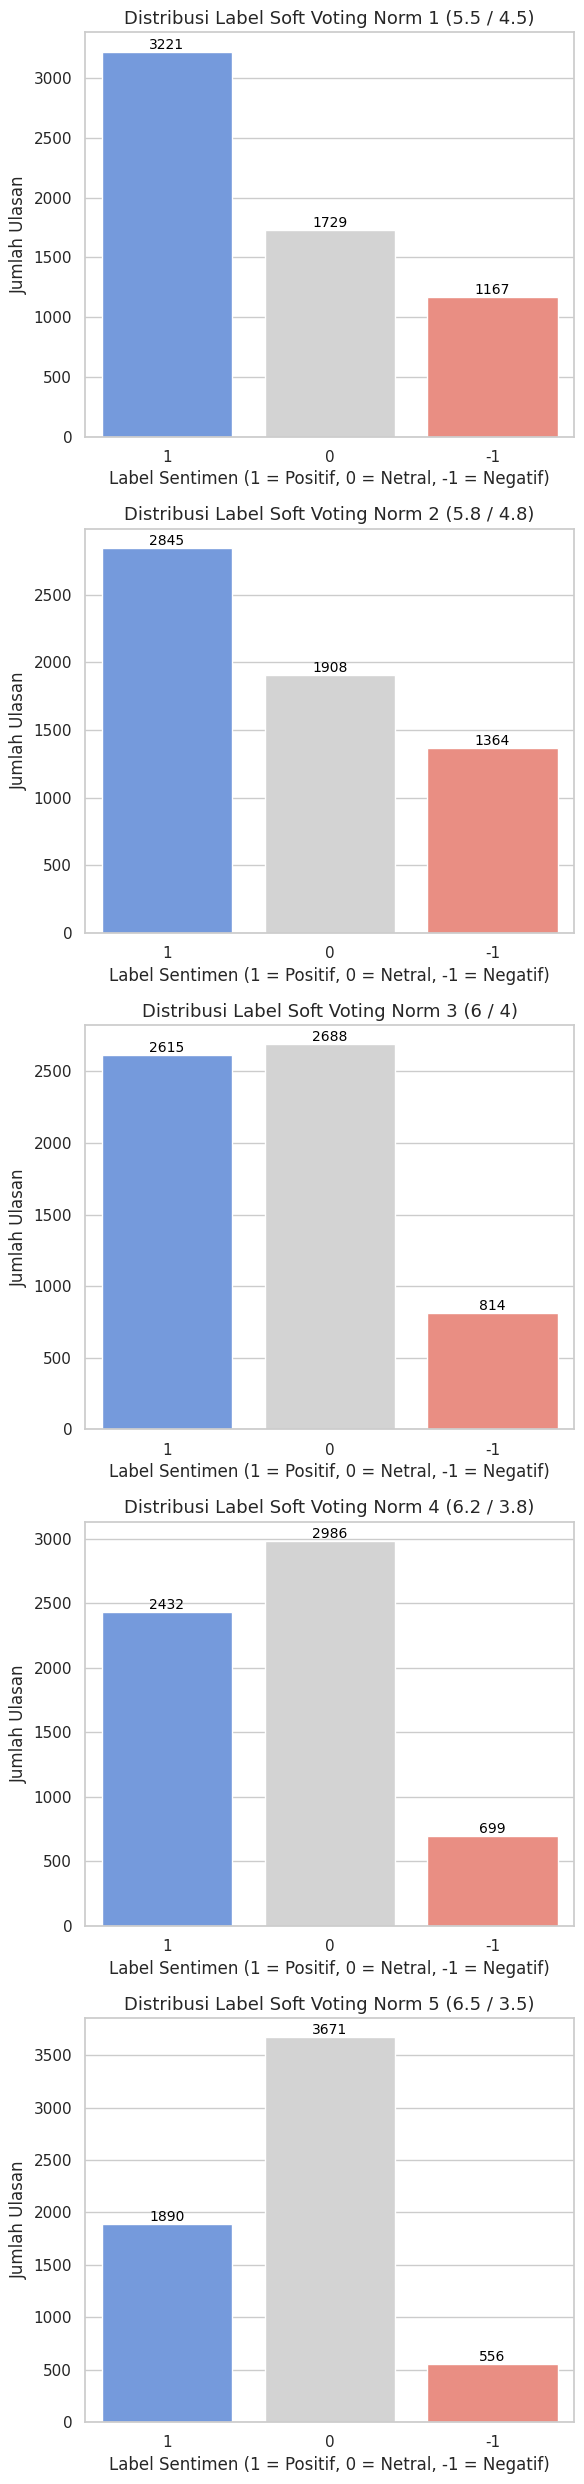

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Daftar kolom yang akan diplot
sv_cols = ["sv_label_norm1", "sv_label_norm2", "sv_label_norm3", "sv_label_norm4", "sv_label_norm5"]
titles  = ["Soft Voting Norm 1 (5.5 / 4.5)",
           "Soft Voting Norm 2 (5.8 / 4.8)",
           "Soft Voting Norm 3 (6 / 4)",
           "Soft Voting Norm 4 (6.2 / 3.8)",
           "Soft Voting Norm 5 (6.5 / 3.5)"]

# Warna label
label_palette = {1: "cornflowerblue", 0: "lightgrey", -1: "salmon"}

# Buat subplot 3 baris
fig, axes = plt.subplots(5, 1, figsize=(6, 25))

for ax, col, title in zip(axes, sv_cols, titles):

    sns.countplot(
        data=df,
        x=col,
        hue=col,
        palette=label_palette,
        order=[1, 0, -1],
        legend=False,
        ax=ax
    )

    ax.set_title(f"Distribusi Label {title}", fontsize=13)
    ax.set_xlabel("Label Sentimen (1 = Positif, 0 = Netral, -1 = Negatif)")
    ax.set_ylabel("Jumlah Ulasan")

    # Label angka di atas bar
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            fontsize=10, color='black',
            xytext=(0, 5), textcoords='offset points'
        )

plt.tight_layout()
plt.show()

In [ ]:
columns_to_save = ["content", "content_en",
    "compound_score", "vader_norm", "vader_label",
    "score", "afinn_norm", "afinn_label",
    "polarity_score", "textblob_norm", "textblob_label",
    "avg_score", "soft_voting_label",
    "avg_norm", "sv_label_norm1", "sv_label_norm2", "sv_label_norm3", "sv_label_norm4", "sv_label_norm5"]
df_subset = df[columns_to_save]
df_subset.to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/labels7.csv", index=False, encoding="utf-8-sig")
print(f"Data labels berhasil disimpan")

Data labels berhasil disimpan


# **Teks Preprocessing**

In [5]:
# from google.colab import drive
# drive.mount("/content/drive")

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/unique_traveloka_reviews.csv")
df = pd.DataFrame(df[["content"]])
df.head(20)

,content
0,kecewa dgn Traveloka pembayaran tetap waktu tp...
1,cepat tepat singkat luar biasa
2,puas dengan aplikasi ini 👍
3,Sangat memuaskan proses cepat
4,Mantap 💯🙏
5,. d .. 'zzo
6,Good job....
7,mudah pesan hotel dan banyak promonya
8,mudah dan aman
9,terima kasih


## **Data Cleaning**

**Deleting Emoji, Symbol, and Number**

In [ ]:
import re
# Delete emoji
def remove_emoji(sentiment):
    if sentiment is not None and isinstance(sentiment, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F700-\U0001F77F"  # alchemical symbols
                                   u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                   u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                   u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                   u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                   u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                   u"\U00002702-\U000027B0"  # Additional emoticons
                                   u"\U000024C2-\U0001F251"  # flags
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', sentiment)
    else:
        return sentiment

# Delete symbol
def remove_symbols(sentiment):
    if sentiment is not None and isinstance(sentiment, str):
        sentiment = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentiment)
    return sentiment

# Delete number
def remove_numbers(sentiment):
    if sentiment is not None and isinstance(sentiment, str):
        sentiment = re.sub(r'\d', '', sentiment)
    return sentiment

df['cleaning'] = df['content']
df['cleaning'] = df['cleaning'].apply(lambda x: remove_emoji(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_symbols(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_numbers(x))
df.head(50)

,content,cleaning
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn Traveloka pembayaran tetap waktu tp...
1,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa
2,puas dengan aplikasi ini 👍,puas dengan aplikasi ini
3,Sangat memuaskan proses cepat,Sangat memuaskan proses cepat
4,Mantap 💯🙏,Mantap
5,. d .. 'zzo,d zzo
6,Good job....,Good job
7,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya
8,mudah dan aman,mudah dan aman
9,terima kasih,terima kasih


## **Case Folding**

In [ ]:
def case_folding(text):
  if isinstance(text, str):
    lowercase = text.lower()
    return lowercase
  else:
    return text
df["case_folding"] = df["cleaning"].apply(case_folding)
df.head(50)

,content,cleaning,case_folding
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn traveloka pembayaran tetap waktu tp...
1,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa
2,puas dengan aplikasi ini 👍,puas dengan aplikasi ini,puas dengan aplikasi ini
3,Sangat memuaskan proses cepat,Sangat memuaskan proses cepat,sangat memuaskan proses cepat
4,Mantap 💯🙏,Mantap,mantap
5,. d .. 'zzo,d zzo,d zzo
6,Good job....,Good job,good job
7,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya
8,mudah dan aman,mudah dan aman,mudah dan aman
9,terima kasih,terima kasih,terima kasih


## **Normalization**

kamus slang 15186

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fornigulo/kamus-slag
!unzip kamus-slag.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open kamus-slag.zip, kamus-slag.zip.zip or kamus-slag.zip.ZIP.


In [ ]:
kamus_slang = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/kamuskatabaku.xlsx")
kamus_tidak_baku = dict(zip(kamus_slang["tidak_baku"], kamus_slang["kata_baku"]))
kamus_slang.head(10)

,tidak_baku,kata_baku
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa
5,eeeehhhh,eh
6,kata2nyaaa,kata-katanya
7,hallo,halo
8,kaka,kakak
9,ka,kak


In [ ]:
# Fungsi normalisasi kata tidak baku
def normalization(text, kamus_tidak_baku):
    if not isinstance(text, str):
        return ""
    return ' '.join([kamus_tidak_baku.get(word, word) for word in text.split()])

# Terapkan ke kolom case_folding
df["hasil_normalisasi"] = df["case_folding"].apply(lambda x: normalization(x, kamus_tidak_baku))

df.head(50)

,content,cleaning,case_folding,hasil_normalisasi
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn traveloka pembayaran tetap waktu tp...,kecewa dengan traveloka pembayaran tetap waktu...
1,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa
2,puas dengan aplikasi ini 👍,puas dengan aplikasi ini,puas dengan aplikasi ini,puas dengan aplikasi ini
3,Sangat memuaskan proses cepat,Sangat memuaskan proses cepat,sangat memuaskan proses cepat,sangat memuaskan proses cepat
4,Mantap 💯🙏,Mantap,mantap,mantap
5,. d .. 'zzo,d zzo,d zzo,di zzo
6,Good job....,Good job,good job,good job
7,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya
8,mudah dan aman,mudah dan aman,mudah dan aman,mudah dan aman
9,terima kasih,terima kasih,terima kasih,terima kasih


## **Tokenizing**

In [ ]:
def tokenize(text):
    tokens = text.split()
    return tokens
df["token"] = df["hasil_normalisasi"].apply(tokenize)
df[["content", "cleaning", "case_folding", "hasil_normalisasi", "token"]].head(50)

,content,cleaning,case_folding,hasil_normalisasi,token
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn traveloka pembayaran tetap waktu tp...,kecewa dengan traveloka pembayaran tetap waktu...,"[kecewa, dengan, traveloka, pembayaran, tetap,..."
1,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,"[cepat, tepat, singkat, luar, biasa]"
2,puas dengan aplikasi ini 👍,puas dengan aplikasi ini,puas dengan aplikasi ini,puas dengan aplikasi ini,"[puas, dengan, aplikasi, ini]"
3,Sangat memuaskan proses cepat,Sangat memuaskan proses cepat,sangat memuaskan proses cepat,sangat memuaskan proses cepat,"[sangat, memuaskan, proses, cepat]"
4,Mantap 💯🙏,Mantap,mantap,mantap,[mantap]
5,. d .. 'zzo,d zzo,d zzo,di zzo,"[di, zzo]"
6,Good job....,Good job,good job,good job,"[good, job]"
7,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,"[mudah, pesan, hotel, dan, banyak, promonya]"
8,mudah dan aman,mudah dan aman,mudah dan aman,mudah dan aman,"[mudah, dan, aman]"
9,terima kasih,terima kasih,terima kasih,terima kasih,"[terima, kasih]"


## **Stopword Removal**

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stop_words = stopwords.words("indonesian")

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df["stopword_removal"] = df["token"].apply(lambda x: remove_stopwords(x))
df[["content", "cleaning", "case_folding", "hasil_normalisasi", "token", "stopword_removal"]].head(50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,content,cleaning,case_folding,hasil_normalisasi,token,stopword_removal
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn traveloka pembayaran tetap waktu tp...,kecewa dengan traveloka pembayaran tetap waktu...,"[kecewa, dengan, traveloka, pembayaran, tetap,...","[kecewa, traveloka, pembayaran, pakai, tpaylat..."
1,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,"[cepat, tepat, singkat, luar, biasa]","[cepat, singkat]"
2,puas dengan aplikasi ini 👍,puas dengan aplikasi ini,puas dengan aplikasi ini,puas dengan aplikasi ini,"[puas, dengan, aplikasi, ini]","[puas, aplikasi]"
3,Sangat memuaskan proses cepat,Sangat memuaskan proses cepat,sangat memuaskan proses cepat,sangat memuaskan proses cepat,"[sangat, memuaskan, proses, cepat]","[memuaskan, proses, cepat]"
4,Mantap 💯🙏,Mantap,mantap,mantap,[mantap],[mantap]
5,. d .. 'zzo,d zzo,d zzo,di zzo,"[di, zzo]",[zzo]
6,Good job....,Good job,good job,good job,"[good, job]","[good, job]"
7,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,"[mudah, pesan, hotel, dan, banyak, promonya]","[mudah, pesan, hotel, promonya]"
8,mudah dan aman,mudah dan aman,mudah dan aman,mudah dan aman,"[mudah, dan, aman]","[mudah, aman]"
9,terima kasih,terima kasih,terima kasih,terima kasih,"[terima, kasih]","[terima, kasih]"


## **Stemming**

In [ ]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

df["stemming"] = df["stopword_removal"].apply(lambda x: " ".join(stemming(x)))
df[["content", "cleaning", "case_folding", "hasil_normalisasi", "token", "stopword_removal", "stemming"]].head(50)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


,content,cleaning,case_folding,hasil_normalisasi,token,stopword_removal,stemming
0,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn Traveloka pembayaran tetap waktu tp...,kecewa dgn traveloka pembayaran tetap waktu tp...,kecewa dengan traveloka pembayaran tetap waktu...,"[kecewa, dengan, traveloka, pembayaran, tetap,...","[kecewa, traveloka, pembayaran, pakai, tpaylat...",kecewa traveloka bayar pakai tpaylater nya kon...
1,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,cepat tepat singkat luar biasa,"[cepat, tepat, singkat, luar, biasa]","[cepat, singkat]",cepat singkat
2,puas dengan aplikasi ini 👍,puas dengan aplikasi ini,puas dengan aplikasi ini,puas dengan aplikasi ini,"[puas, dengan, aplikasi, ini]","[puas, aplikasi]",puas aplikasi
3,Sangat memuaskan proses cepat,Sangat memuaskan proses cepat,sangat memuaskan proses cepat,sangat memuaskan proses cepat,"[sangat, memuaskan, proses, cepat]","[memuaskan, proses, cepat]",muas proses cepat
4,Mantap 💯🙏,Mantap,mantap,mantap,[mantap],[mantap],mantap
5,. d .. 'zzo,d zzo,d zzo,di zzo,"[di, zzo]",[zzo],zzo
6,Good job....,Good job,good job,good job,"[good, job]","[good, job]",good job
7,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,mudah pesan hotel dan banyak promonya,"[mudah, pesan, hotel, dan, banyak, promonya]","[mudah, pesan, hotel, promonya]",mudah pesan hotel promonya
8,mudah dan aman,mudah dan aman,mudah dan aman,mudah dan aman,"[mudah, dan, aman]","[mudah, aman]",mudah aman
9,terima kasih,terima kasih,terima kasih,terima kasih,"[terima, kasih]","[terima, kasih]",terima kasih


## **Data Checking After Preprocessing**

In [ ]:
print("\nJumlah baris kosong per kolom:")
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {(df[col].astype(str).str.strip() == '').sum()}")


Jumlah baris kosong per kolom:
content: 0
cleaning: 34
case_folding: 34
hasil_normalisasi: 34
token: 0
stopword_removal: 0
stemming: 85


In [ ]:
import numpy as np

# Ganti string kosong dan string yang hanya berisi spasi kosong dengan NaN
for col in df.columns:
    if df[col].dtype == "object":
        df[col].replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Hapus baris dengan nilai NaN
df.dropna(inplace=True)

/tmp/ipython-input-2196083671.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(r'^\s*$', np.nan, regex=True, inplace=True)


In [ ]:
print("\nJumlah baris kosong per kolom:")
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {(df[col].astype(str).str.strip() == '').sum()}")


Jumlah baris kosong per kolom:
content: 0
cleaning: 0
case_folding: 0
hasil_normalisasi: 0
token: 0
stopword_removal: 0
stemming: 0


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/preprocessing4.csv", index=False)
print("Data disimpan ke Google Drive")

Data have been saved to Google Drive


# **Splitting Dataset**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/labels7.csv")
df_preprocessed = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/preprocessing4.csv")

# Gabungkan data preprocessing ('stemming') dengan labels dataframe
df = pd.merge(df, df_preprocessed[['content', 'stemming']], on='content', how='left')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   content            6117 non-null   object 
 1   content_en         6115 non-null   object 
 2   compound_score     6117 non-null   float64
 3   vader_norm         6117 non-null   float64
 4   vader_label        6117 non-null   int64  
 5   score              6117 non-null   float64
 6   afinn_norm         6117 non-null   float64
 7   afinn_label        6117 non-null   int64  
 8   polarity_score     6117 non-null   float64
 9   textblob_norm      6117 non-null   float64
 10  textblob_label     6117 non-null   int64  
 11  avg_score          6117 non-null   float64
 12  soft_voting_label  6117 non-null   int64  
 13  avg_norm           6117 non-null   float64
 14  sv_label_norm1     6117 non-null   int64  
 15  sv_label_norm2     6117 non-null   int64  
 16  sv_label_norm3     6117 

In [ ]:
# Hapus baris dengan nilai kosong di kolom 'stemming'
df.dropna(subset=['stemming'], inplace=True)

print(f"\nJumlah baris setelah menghapus baris dengan 'stemming' kosong: {len(df)}")


Jumlah baris setelah menghapus baris dengan 'stemming' kosong: 6032


In [ ]:
# !pip install scikit-learn

In [ ]:
# Split dataset ratio 80:20
from sklearn.model_selection import train_test_split

x = df['stemming'].astype(str)

# Split
x_train, x_test = train_test_split(x, test_size = 0.2, random_state = 42)

# Menyimpan index untuk ambil y sesuai
train_idx = x_train.index
test_idx = x_test.index

y_train_vader   = df['vader_label'].loc[train_idx]
y_test_vader    = df['vader_label'].loc[test_idx]

y_train_afinn   = df['afinn_label'].loc[train_idx]
y_test_afinn    = df['afinn_label'].loc[test_idx]

y_train_textblob = df['textblob_label'].loc[train_idx]
y_test_textblob  = df['textblob_label'].loc[test_idx]

y_train_sv     = df['soft_voting_label'].loc[train_idx]
y_test_sv      = df['soft_voting_label'].loc[test_idx]

y_train_sv_norm1 = df['sv_label_norm1'].loc[train_idx]
y_test_sv_norm1  = df['sv_label_norm1'].loc[test_idx]

y_train_sv_norm2 = df['sv_label_norm2'].loc[train_idx]
y_test_sv_norm2  = df['sv_label_norm2'].loc[test_idx]

y_train_sv_norm3 = df['sv_label_norm3'].loc[train_idx]
y_test_sv_norm3  = df['sv_label_norm3'].loc[test_idx]

y_train_sv_norm4 = df['sv_label_norm4'].loc[train_idx]
y_test_sv_norm4  = df['sv_label_norm4'].loc[test_idx]

y_train_sv_norm5 = df['sv_label_norm5'].loc[train_idx]
y_test_sv_norm5  = df['sv_label_norm5'].loc[test_idx]

# **TF-IDF**

In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000, min_df=3, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf  = vectorizer.transform(x_test)

# Konversi matriks ke DataFrame (supaya bisa disimpan ke csv)
tfidf_train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_test_df  = pd.DataFrame(X_test_tfidf.toarray(),  columns=vectorizer.get_feature_names_out())

In [ ]:
# Simpan hasil tfidf ke drive
tfidf_train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/tfidf_train1.csv", index=False, encoding='utf-8-sig')
tfidf_test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/tfidf_test1.csv",  index=False, encoding='utf-8-sig')
print("File TF-IDF berhasil disimpan di Google Drive")

File TF-IDF berhasil disimpan di Google Drive


In [ ]:
# Summary top-N TF-IDF
top_n = 10
top_tfidf = tfidf_train_df.apply(lambda row: pd.Series({
    "Top Words": row.nlargest(top_n).index.tolist(),
    "Top Values": row.nlargest(top_n).values.tolist()
}), axis=1)

print("\nTop 10 TF-IDF per Dokumen:")
top_tfidf.head(10)


Top 10 TF-IDF per Dokumen:


,Top Words,Top Values
0,"[selisih, agoda, harga mahal, ribu, mahal, har...","[0.5023668583292736, 0.4694173708103452, 0.455..."
1,"[cicil, traveloka hati, guna traveloka, hati, ...","[0.5496415076080418, 0.3283040300633688, 0.295..."
2,"[aktif paylater, hati pakai, rumah, korban, te...","[0.32137879581488155, 0.31252031976505606, 0.2..."
3,"[aman nyaman, selamat, aman, nyaman, ac, acc, ...","[0.5767559741212275, 0.5631547458543362, 0.422..."
4,"[an, alhamdulillah, bandara, tinggal, pergi, l...","[0.43058403039853765, 0.39422182135219336, 0.3..."
5,"[cs nya, hati, kasih traveloka, cs, terima kas...","[0.44714317229991135, 0.3845524585943152, 0.35..."
6,"[kirim, iklan, tolong, ac, acc, aco, ada, admi...","[0.6754156735048753, 0.5405822471393336, 0.501..."
7,"[kena, nya kena, situasi, beli, banget, beli t...","[0.3996691437031607, 0.2674956663109387, 0.267..."
8,"[mengunakan, trveloka, bagus, ac, acc, aco, ad...","[0.6720240095695807, 0.6720240095695807, 0.311..."
9,"[sesal pakai, harga, aplikasi tipu, beda harga...","[0.34238015487861834, 0.320984961533327, 0.313..."


In [ ]:
jumlah_fitur = len(vectorizer.get_feature_names_out())
print(f"Jumlah fitur: {jumlah_fitur}")

Jumlah fitur: 2000


# **SMOTE, SVM, Evaluasi**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


===== Label: VADER =====
Before SMOTE: vader_label
 1    2581
 0    1148
-1    1096
Name: count, dtype: int64
After SMOTE: vader_label
 0    2581
 1    2581
-1    2581
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
42,rbf,10.0,scale,0.842052,0.006423,1
46,rbf,10.0,1.0,0.841535,0.007591,2
62,rbf,100.0,scale,0.837401,0.004975,3
66,rbf,100.0,1.0,0.837272,0.005354,4
70,rbf,100.0,0.1,0.832235,0.006993,5


Best Parameter for VADER : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8421
Test Accuracy : 0.7349
Test Precision : 0.7046
Test Recall : 0.7123
Test F1-Score : 0.7075

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.67      0.74      0.70       258
           0       0.63      0.59      0.61       311
           1       0.81      0.80      0.81       638

    accuracy                           0.73      1207
   macro avg       0.70      0.71      0.71      1207
weighted avg       0.74      0.73      0.73      1207


 Confusion Matrix untuk VADER
           Pred_-1  Pred_0  Pred_1
Actual_-1      192      33      33
Actual_0        42     184      85
Actual_1        53      74     511


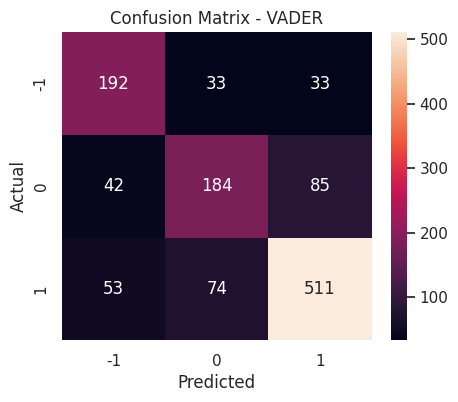


===== Label: AFINN =====
Before SMOTE: afinn_label
 1    2404
 0    1411
-1    1010
Name: count, dtype: int64
After SMOTE: afinn_label
 0    2404
 1    2404
-1    2404
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
42,rbf,10.0,scale,0.819327,0.008876,1
46,rbf,10.0,1.0,0.818634,0.007626,2
66,rbf,100.0,1.0,0.815306,0.009175,3
62,rbf,100.0,scale,0.814474,0.008525,4
70,rbf,100.0,0.1,0.814336,0.005342,5


Best Parameter for AFINN : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8193
Test Accuracy : 0.6968
Test Precision : 0.6678
Test Recall : 0.6734
Test F1-Score : 0.6701

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.60      0.65      0.63       233
           0       0.62      0.59      0.60       370
           1       0.78      0.78      0.78       604

    accuracy                           0.70      1207
   macro avg       0.67      0.67      0.67      1207
weighted avg       0.70      0.70      0.70      1207


 Confusion Matrix untuk AFINN
           Pred_-1  Pred_0  Pred_1
Actual_-1      152      43      38
Actual_0        58     217      95
Actual_1        42      90     472


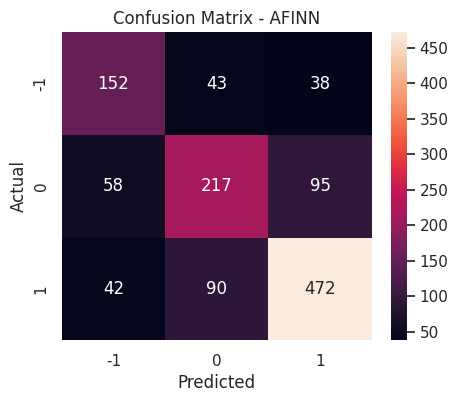


===== Label: TextBlob =====
Before SMOTE: textblob_label
 1    2596
 0    1306
-1     923
Name: count, dtype: int64
After SMOTE: textblob_label
 0    2596
-1    2596
 1    2596
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
42,rbf,10.0,scale,0.816642,0.009935,1
46,rbf,10.0,1.0,0.815101,0.010484,2
66,rbf,100.0,1.0,0.808295,0.005833,3
62,rbf,100.0,scale,0.807654,0.007898,4
70,rbf,100.0,0.1,0.801747,0.012347,5


Best Parameter for TextBlob : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8166
Test Accuracy : 0.6885
Test Precision : 0.6492
Test Recall : 0.6531
Test F1-Score : 0.6511

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.58      0.60      0.59       206
           0       0.59      0.60      0.60       338
           1       0.77      0.76      0.77       663

    accuracy                           0.69      1207
   macro avg       0.65      0.65      0.65      1207
weighted avg       0.69      0.69      0.69      1207


 Confusion Matrix untuk TextBlob
           Pred_-1  Pred_0  Pred_1
Actual_-1      123      34      49
Actual_0        37     203      98
Actual_1        51     107     505


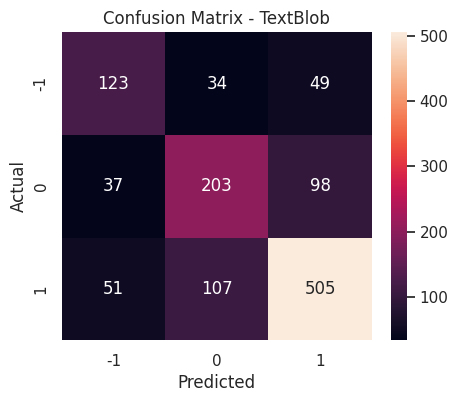


===== Label: Soft Voting =====
Before SMOTE: soft_voting_label
 1    2935
-1    1207
 0     683
Name: count, dtype: int64
After SMOTE: soft_voting_label
 0    2935
 1    2935
-1    2935
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
62,rbf,100.0,scale,0.880182,0.004885,1
66,rbf,100.0,1.0,0.878819,0.006599,2
42,rbf,10.0,scale,0.875639,0.003885,3
46,rbf,10.0,1.0,0.875185,0.005851,4
70,rbf,100.0,0.1,0.859625,0.002992,5


Best Parameter for Soft Voting : {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8802
Test Accuracy : 0.7539
Test Precision : 0.6806
Test Recall : 0.7007
Test F1-Score : 0.6896

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.69      0.72      0.70       287
           0       0.51      0.58      0.54       170
           1       0.85      0.81      0.83       750

    accuracy                           0.75      1207
   macro avg       0.68      0.70      0.69      1207
weighted avg       0.76      0.75      0.76      1207


 Confusion Matrix untuk Soft Voting
           Pred_-1  Pred_0  Pred_1
Actual_-1      206      24      57
Actual_0        22      98      50
Actual_1        72      72     606


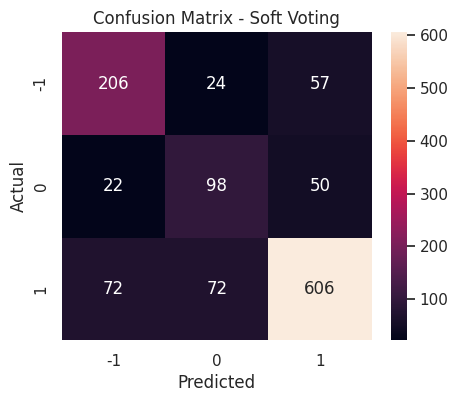


===== Label: Soft Voting Norm1 =====
Before SMOTE: sv_label_norm1
 1    2552
 0    1337
-1     936
Name: count, dtype: int64
After SMOTE: sv_label_norm1
 0    2552
 1    2552
-1    2552
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
46,rbf,10.0,1.0,0.824844,0.004120,1
42,rbf,10.0,scale,0.824452,0.004677,2
70,rbf,100.0,0.1,0.822231,0.006346,3
26,rbf,1.0,1.0,0.818705,0.005222,4
22,rbf,1.0,scale,0.817267,0.007000,5


Best Parameter for Soft Voting Norm1 : {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8248
Test Accuracy : 0.7150
Test Precision : 0.6798
Test Recall : 0.6921
Test F1-Score : 0.6852

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.63      0.70      0.66       227
           0       0.58      0.59      0.58       351
           1       0.83      0.79      0.81       629

    accuracy                           0.71      1207
   macro avg       0.68      0.69      0.69      1207
weighted avg       0.72      0.71      0.72      1207


 Confusion Matrix untuk Soft Voting Norm1
           Pred_-1  Pred_0  Pred_1
Actual_-1      158      53      16
Actual_0        62     206      83
Actual_1        31      99     499


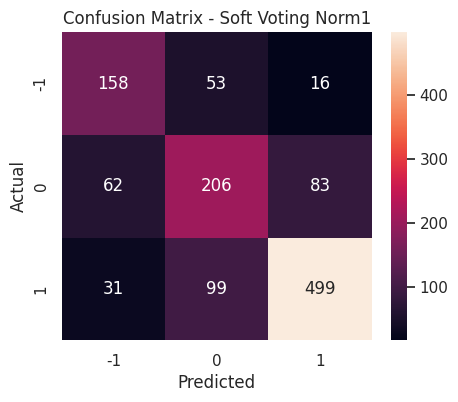


===== Label: Soft Voting Norm2 =====
Before SMOTE: sv_label_norm2
 1    2255
 0    1477
-1    1093
Name: count, dtype: int64
After SMOTE: sv_label_norm2
 0    2255
-1    2255
 1    2255
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
22,rbf,1.0,scale,0.789505,0.007529,1
46,rbf,10.0,1.0,0.787583,0.015273,2
42,rbf,10.0,scale,0.786844,0.014816,3
66,rbf,100.0,1.0,0.784479,0.015266,4
70,rbf,100.0,0.1,0.783888,0.013382,5


Best Parameter for Soft Voting Norm2 : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.7895
Test Accuracy : 0.7332
Test Precision : 0.7143
Test Recall : 0.7280
Test F1-Score : 0.7189

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.66      0.78      0.71       266
           0       0.66      0.60      0.63       389
           1       0.83      0.80      0.82       552

    accuracy                           0.73      1207
   macro avg       0.71      0.73      0.72      1207
weighted avg       0.74      0.73      0.73      1207


 Confusion Matrix untuk Soft Voting Norm2
           Pred_-1  Pred_0  Pred_1
Actual_-1      207      45      14
Actual_0        76     234      79
Actual_1        33      75     444


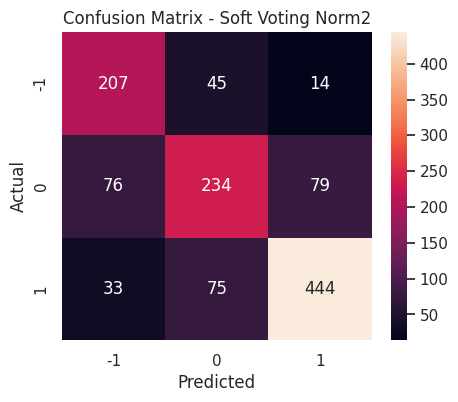


===== Label: Soft Voting Norm3 =====
Before SMOTE: sv_label_norm3
 0    2093
 1    2074
-1     658
Name: count, dtype: int64
After SMOTE: sv_label_norm3
 0    2093
-1    2093
 1    2093
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
22,rbf,1.0,scale,0.804907,0.009768,1
26,rbf,1.0,1.0,0.803314,0.009266,2
46,rbf,10.0,1.0,0.799809,0.010385,3
42,rbf,10.0,scale,0.799491,0.009148,4
6,rbf,0.5,1.0,0.786432,0.012682,5


Best Parameter for Soft Voting Norm3 : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8049
Test Accuracy : 0.7249
Test Precision : 0.6753
Test Recall : 0.6597
Test F1-Score : 0.6663

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.51      0.45      0.47       155
           0       0.69      0.75      0.72       547
           1       0.83      0.79      0.81       505

    accuracy                           0.72      1207
   macro avg       0.68      0.66      0.67      1207
weighted avg       0.72      0.72      0.72      1207


 Confusion Matrix untuk Soft Voting Norm3
           Pred_-1  Pred_0  Pred_1
Actual_-1       69      84       2
Actual_0        56     409      82
Actual_1        11      97     397


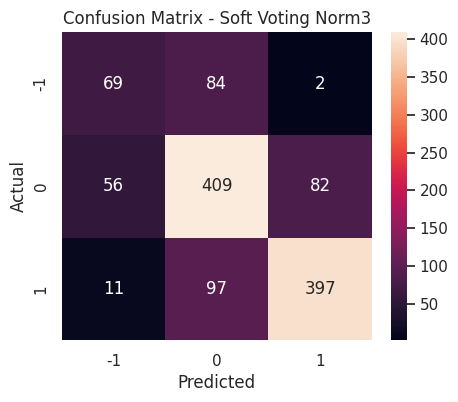


===== Label: Soft Voting Norm4 =====
Before SMOTE: sv_label_norm4
 0    2330
 1    1934
-1     561
Name: count, dtype: int64
After SMOTE: sv_label_norm4
 0    2330
-1    2330
 1    2330
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
46,rbf,10.0,1.0,0.831617,0.004758,1
42,rbf,10.0,scale,0.831044,0.005455,2
22,rbf,1.0,scale,0.830901,0.007844,3
26,rbf,1.0,1.0,0.827754,0.008950,4
66,rbf,100.0,1.0,0.817310,0.007162,5


Best Parameter for Soft Voting Norm4 : {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8316
Test Accuracy : 0.7258
Test Precision : 0.6698
Test Recall : 0.6779
Test F1-Score : 0.6736

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.49      0.53      0.51       137
           0       0.74      0.73      0.74       603
           1       0.78      0.78      0.78       467

    accuracy                           0.73      1207
   macro avg       0.67      0.68      0.67      1207
weighted avg       0.73      0.73      0.73      1207


 Confusion Matrix untuk Soft Voting Norm4
           Pred_-1  Pred_0  Pred_1
Actual_-1       72      56       9
Actual_0        68     442      93
Actual_1         8      97     362


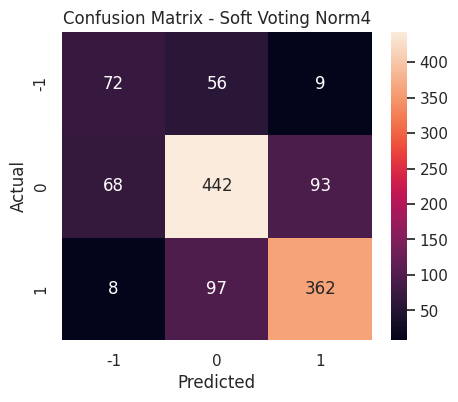


===== Label: Soft Voting Norm5 =====
Before SMOTE: sv_label_norm5
 0    2877
 1    1500
-1     448
Name: count, dtype: int64
After SMOTE: sv_label_norm5
 0    2877
 1    2877
-1    2877
Name: count, dtype: int64

=== Hasil lengkap GridSearchCV ===


,param_kernel,param_C,param_gamma,mean_test_score,std_test_score,rank_test_score
42,rbf,10.0,scale,0.877187,0.003486,1
46,rbf,10.0,1.0,0.875565,0.003390,2
22,rbf,1.0,scale,0.868382,0.003013,3
26,rbf,1.0,1.0,0.861546,0.003636,4
70,rbf,100.0,0.1,0.854016,0.007940,5


Best Parameter for Soft Voting Norm5 : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy (Train) : 0.8772
Test Accuracy : 0.7407
Test Precision : 0.6582
Test Recall : 0.6620
Test F1-Score : 0.6598

=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.45      0.48      0.46       108
           0       0.79      0.79      0.79       733
           1       0.74      0.71      0.72       366

    accuracy                           0.74      1207
   macro avg       0.66      0.66      0.66      1207
weighted avg       0.74      0.74      0.74      1207


 Confusion Matrix untuk Soft Voting Norm5
           Pred_-1  Pred_0  Pred_1
Actual_-1       52      54       2
Actual_0        61     582      90
Actual_1         3     103     260


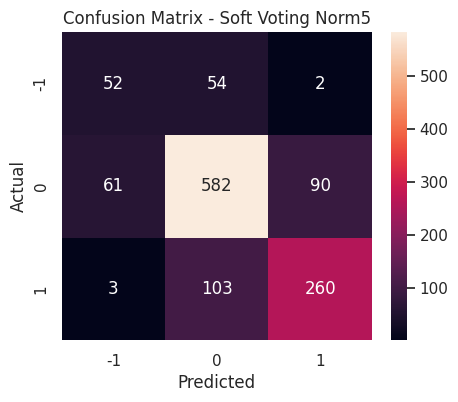

In [ ]:
model = SVC(random_state = 0, class_weight='balanced')

# Parameter grid untuk GridSearchCV
parameters = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C'      : [0.5, 1, 10, 100],
    'gamma'  : ['scale', 1.0, 0.1, 0.01, 0.001]
}

# Daftar semua label
label_sets = {
    "VADER" : (y_train_vader, y_test_vader),
    "AFINN" : (y_train_afinn, y_test_afinn),
    "TextBlob" : (y_train_textblob, y_test_textblob),
    "Soft Voting" : (y_train_sv, y_test_sv),
    "Soft Voting Norm1" : (y_train_sv_norm1, y_test_sv_norm1),
    "Soft Voting Norm2" : (y_train_sv_norm2, y_test_sv_norm2),
    "Soft Voting Norm3" : (y_train_sv_norm3, y_test_sv_norm3),
    "Soft Voting Norm4" : (y_train_sv_norm4, y_test_sv_norm4),
    "Soft Voting Norm5" : (y_train_sv_norm5, y_test_sv_norm5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_results = {}
all_results = {}
cm_matrices = {}

for label_name, (y_tr, y_te) in label_sets.items():
    print(f"\n===== Label: {label_name} =====")

    # =========================
    #         SMOTE
    # =========================
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_tfidf, y_tr)

    print("Before SMOTE:", pd.Series(y_tr).value_counts())
    print("After SMOTE:", pd.Series(y_train_res).value_counts())

    # =========================
    #     Grid Search SVM
    # =========================
    grid_search = GridSearchCV(
        estimator = model,
        param_grid = parameters,
        scoring = 'accuracy',
        n_jobs = -1,
        cv=cv,
        verbose = 0
    )
    # Fit model training hasil SMOTE
    grid_search.fit(X_train_res, y_train_res) # hitung margin max hyperplane

    # Tampilkan seluruh hasil kombinasi kernel, C, dan gamma
    results = pd.DataFrame(grid_search.cv_results_)
    results = results[['param_kernel','param_C','param_gamma','mean_test_score',
                       'std_test_score','rank_test_score']].sort_values('rank_test_score')

    print("\n=== Hasil lengkap GridSearchCV ===")
    display(results.head(5))  # 5 baris teratas

    # Best model
    best_model = grid_search.best_estimator_ # menentukan bobot w dan b
    print(f"Best Parameter for {label_name} : {grid_search.best_params_}")
    print(f"Best Accuracy (Train) : {grid_search.best_score_:.4f}")

    # =================================
    #     Evaluasi Confusion Matrix
    # =================================
    y_pred = best_model.predict(X_test_tfidf)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_te, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_te, y_pred, average="macro", zero_division=0)

    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test Precision : {prec:.4f}")
    print(f"Test Recall : {rec:.4f}")
    print(f"Test F1-Score : {f1:.4f}")

    print("\n=== Classification Report ===")
    print(classification_report(y_te, y_pred))

    labels = sorted(list(set(y_te)))
    cm = confusion_matrix(y_te, y_pred, labels=labels)

    cm_matrices[label_name] = cm
    print("\n Confusion Matrix untuk", label_name )
    print(pd.DataFrame(cm,
                       index=[f"Actual_{l}" for l in labels],
                       columns=[f"Pred_{l}" for l in labels]))

    # Plot heatmap confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {label_name}')
    plt.show()

    # Simpan hasil
    best_results[label_name] = {
        "Best Kernel" : grid_search.best_params_['kernel'],
        "Best C" : grid_search.best_params_['C'],
        "Best Gamma" : grid_search.best_params_['gamma'],
        "CV Accuracy" : grid_search.best_score_,
        "Test Accuracy" : acc,
        "Test Precision" : prec,
        "Test Recall" : rec,
        "Test F1-Score" : f1
    }

In [ ]:
# Save all results for the current label
results.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/svm_{label_name}_all_results4.csv", index=False, encoding='utf-8-sig')
all_results[label_name] = results

# Save the summary of best results after the loop
best_df = pd.DataFrame(best_results).T
best_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/svm_gridsearch_best_summary4.csv", encoding='utf-8-sig')
print("\n All Best results telah disimpan di Google Drive.")
display(best_df)


 All Best results telah disimpan di Google Drive.


,Best Kernel,Best C,Best Gamma,CV Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score
VADER,rbf,10,scale,0.842052,0.73488,0.704564,0.712255,0.707504
AFINN,rbf,10,scale,0.819327,0.696769,0.66778,0.673435,0.670131
TextBlob,rbf,10,scale,0.816642,0.688484,0.649198,0.653123,0.651099
Soft Voting,rbf,100,scale,0.880182,0.753935,0.680584,0.700747,0.68959
Soft Voting Norm1,rbf,10,1.0,0.824844,0.714996,0.679783,0.692084,0.685185
Soft Voting Norm2,rbf,1,scale,0.789505,0.733223,0.714299,0.728029,0.718882
Soft Voting Norm3,rbf,1,scale,0.804907,0.724938,0.675312,0.659672,0.666313
Soft Voting Norm4,rbf,10,1.0,0.831617,0.725766,0.669839,0.677903,0.673606
Soft Voting Norm5,rbf,10,scale,0.877187,0.740679,0.658154,0.661954,0.65976


# Analisis Soft Voting (Viz)

In [ ]:
soft_voting_norm_results = best_df[best_df.index.str.contains('Soft Voting Norm')]
display(soft_voting_norm_results.head())

,Best Kernel,Best C,Best Gamma,CV Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score
Soft Voting Norm1,rbf,10,1.0,0.824844,0.714996,0.679783,0.692084,0.685185
Soft Voting Norm2,rbf,1,scale,0.789505,0.733223,0.714299,0.728029,0.718882
Soft Voting Norm3,rbf,1,scale,0.804907,0.724938,0.675312,0.659672,0.666313
Soft Voting Norm4,rbf,10,1.0,0.831617,0.725766,0.669839,0.677903,0.673606
Soft Voting Norm5,rbf,10,scale,0.877187,0.740679,0.658154,0.661954,0.65976


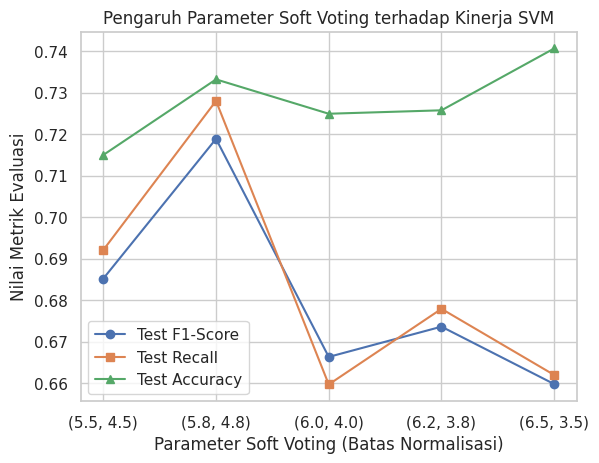

In [ ]:
import matplotlib.pyplot as plt

# Label parameter soft voting (ASLI)
soft_voting_labels = [
    '(5.5, 4.5)',
    '(5.8, 4.8)',
    '(6.0, 4.0)',
    '(6.2, 3.8)',
    '(6.5, 3.5)'
]

# Metrik dari tabel aslimu
test_f1 = [0.685185, 0.718882, 0.666313, 0.673606, 0.659760]
test_recall = [0.692084, 0.728029, 0.659672, 0.677903, 0.661954]
test_accuracy = [0.714996, 0.733223, 0.724938, 0.725766, 0.740679]

plt.figure()
plt.plot(soft_voting_labels, test_f1, marker='o', label='Test F1-Score')
plt.plot(soft_voting_labels, test_recall, marker='s', label='Test Recall')
plt.plot(soft_voting_labels, test_accuracy, marker='^', label='Test Accuracy')

plt.xlabel('Parameter Soft Voting (Batas Normalisasi)')
plt.ylabel('Nilai Metrik Evaluasi')
plt.title('Pengaruh Parameter Soft Voting terhadap Kinerja SVM')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/labels7.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   content            6117 non-null   object 
 1   content_en         6115 non-null   object 
 2   compound_score     6117 non-null   float64
 3   vader_norm         6117 non-null   float64
 4   vader_label        6117 non-null   int64  
 5   score              6117 non-null   float64
 6   afinn_norm         6117 non-null   float64
 7   afinn_label        6117 non-null   int64  
 8   polarity_score     6117 non-null   float64
 9   textblob_norm      6117 non-null   float64
 10  textblob_label     6117 non-null   int64  
 11  avg_score          6117 non-null   float64
 12  soft_voting_label  6117 non-null   int64  
 13  avg_norm           6117 non-null   float64
 14  sv_label_norm1     6117 non-null   int64  
 15  sv_label_norm2     6117 non-null   int64  
 16  sv_label_norm3     6117 

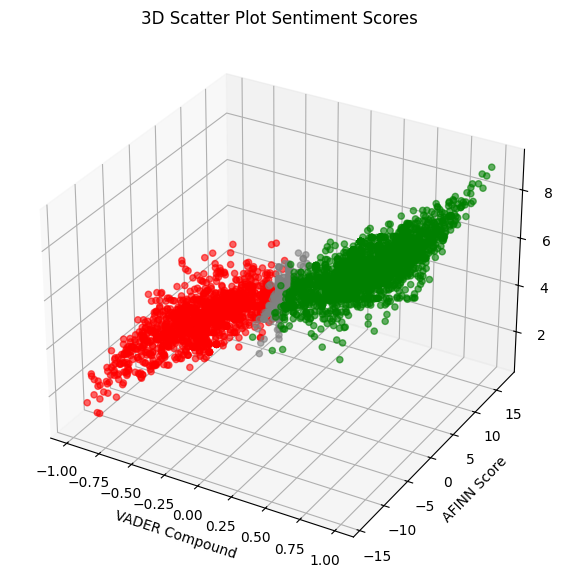

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

colors = df['vader_label'].map({1: 'green', 0: 'gray', -1: 'red'})

ax.scatter(
    df['compound_score'],     # Sumbu X
    df['score'],        # Sumbu Y
    df['avg_norm'],     # Sumbu Z
    c=colors,
    alpha=0.6
)

ax.set_title('3D Scatter Plot Sentiment Scores')
ax.set_xlabel('VADER Compound')
ax.set_ylabel('AFINN Score')
ax.set_zlabel('TextBlob Polarity')

plt.show()